In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import base64
from io import BytesIO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Import pipeline
from app.services.analysis_service import AnalysisService
from app.utils.pipeline_analysis import BabyPostureAnalysisPipeline

# Thiết lập style cho plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Đã import thành công tất cả thư viện!")

Đã import thành công tất cả thư viện!


In [2]:
# Đường dẫn đến các folder chứa ảnh
DAP_CHAN_FOLDER = "dap_chan"  # Thay đổi đường dẫn này nếu cần
KHONG_CHAN_FOLDER = "khong_chan"  # Thay đổi đường dẫn này nếu cần

# Khởi tạo pipeline (thay vì API URL)
# Đường dẫn đến model và scaler - cập nhật theo setup của bạn
MODEL_PATH = "app/models/random_forest.pkl"
SCALER_PATH = "app/models/input_scaler.pkl"

try:
    pipeline = BabyPostureAnalysisPipeline(MODEL_PATH, SCALER_PATH)
    print("✅ Pipeline đã được khởi tạo thành công!")
except Exception as e:
    print(f"❌ Lỗi khởi tạo pipeline: {e}")
    pipeline = None

# Kiểm tra folder tồn tại
dap_chan_exists = os.path.exists(DAP_CHAN_FOLDER)
khong_chan_exists = os.path.exists(KHONG_CHAN_FOLDER)

print(f"Folder '{DAP_CHAN_FOLDER}' tồn tại: {dap_chan_exists}")
print(f"Folder '{KHONG_CHAN_FOLDER}' tồn tại: {khong_chan_exists}")

if not dap_chan_exists or not khong_chan_exists:
    print("⚠️ Vui lòng kiểm tra lại đường dẫn folder!")
elif pipeline is None:
    print("⚠️ Pipeline chưa được khởi tạo!")
else:
    print("✅ Tất cả đều sẵn sàng!")

✅ Pipeline đã được khởi tạo thành công!
Folder 'dap_chan' tồn tại: True
Folder 'khong_chan' tồn tại: True
✅ Tất cả đều sẵn sàng!


In [3]:
def load_images_from_folder(folder_path):
    """Load tất cả ảnh từ folder"""
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    images = []
    
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} không tồn tại!")
        return images
    
    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            images.append(os.path.join(folder_path, filename))
    
    return sorted(images)

# Load ảnh từ cả 2 folders
dap_chan_images = load_images_from_folder(DAP_CHAN_FOLDER)
khong_chan_images = load_images_from_folder(KHONG_CHAN_FOLDER)

# Tạo DataFrame để lưu thông tin
data = []

# Thêm ảnh đắp chăn (label = 1, True)
for img_path in dap_chan_images:
    data.append({
        'image_path': img_path,
        'folder': 'dap_chan',
        'true_label': 1,  # 1 = có đắp chăn
        'true_label_text': 'Có đắp chăn'
    })

# Thêm ảnh không chăn (label = 0, False)  
for img_path in khong_chan_images:
    data.append({
        'image_path': img_path,
        'folder': 'khong_chan', 
        'true_label': 0,  # 0 = không đắp chăn
        'true_label_text': 'Không đắp chăn'
    })

df = pd.DataFrame(data)

print(f"Tổng số ảnh: {len(df)}")
print(f"Số ảnh đắp chăn: {len(dap_chan_images)}")
print(f"Số ảnh không chăn: {len(khong_chan_images)}")
print(f"DataFrame shape: {df.shape}")

Tổng số ảnh: 67
Số ảnh đắp chăn: 31
Số ảnh không chăn: 36
DataFrame shape: (67, 4)


=== THỐNG KÊ DỮ LIỆU ===
true_label_text
Không đắp chăn    36
Có đắp chăn       31
Name: count, dtype: int64

Tỷ lệ phần trăm:
true_label_text
Không đắp chăn    53.731343
Có đắp chăn       46.268657
Name: proportion, dtype: float64


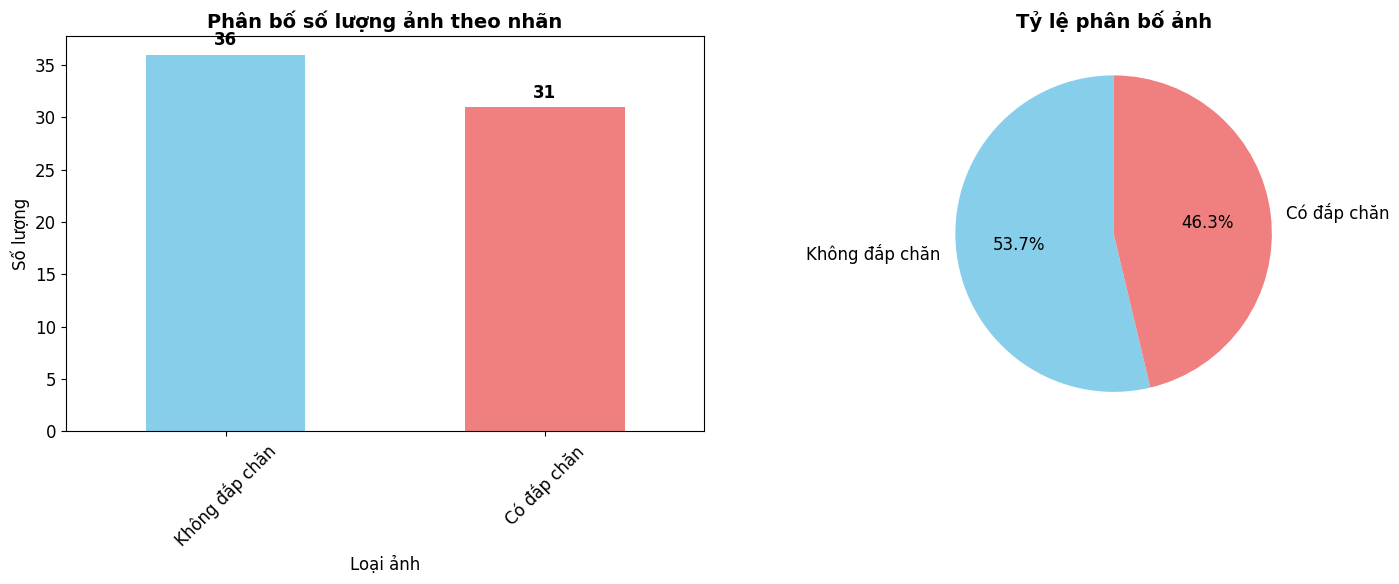


=== MỘT SỐ ẢNH MẪU ===
Đang kiểm tra ảnh đắp chăn...
❌ Không thể đọc ảnh: dap_chan\Bản sao của frame_0029 - Copy (2).jpg
❌ Không thể đọc ảnh: dap_chan\Bản sao của frame_0029 - Copy - Copy.jpg
❌ Không thể đọc ảnh: dap_chan\Bản sao của frame_0029 - Copy.jpg
❌ Không thể đọc ảnh: dap_chan\Bản sao của frame_0029.jpg
Đang kiểm tra ảnh không chăn...
Tìm được 4 ảnh đắp chăn hợp lệ
Tìm được 4 ảnh không chăn hợp lệ


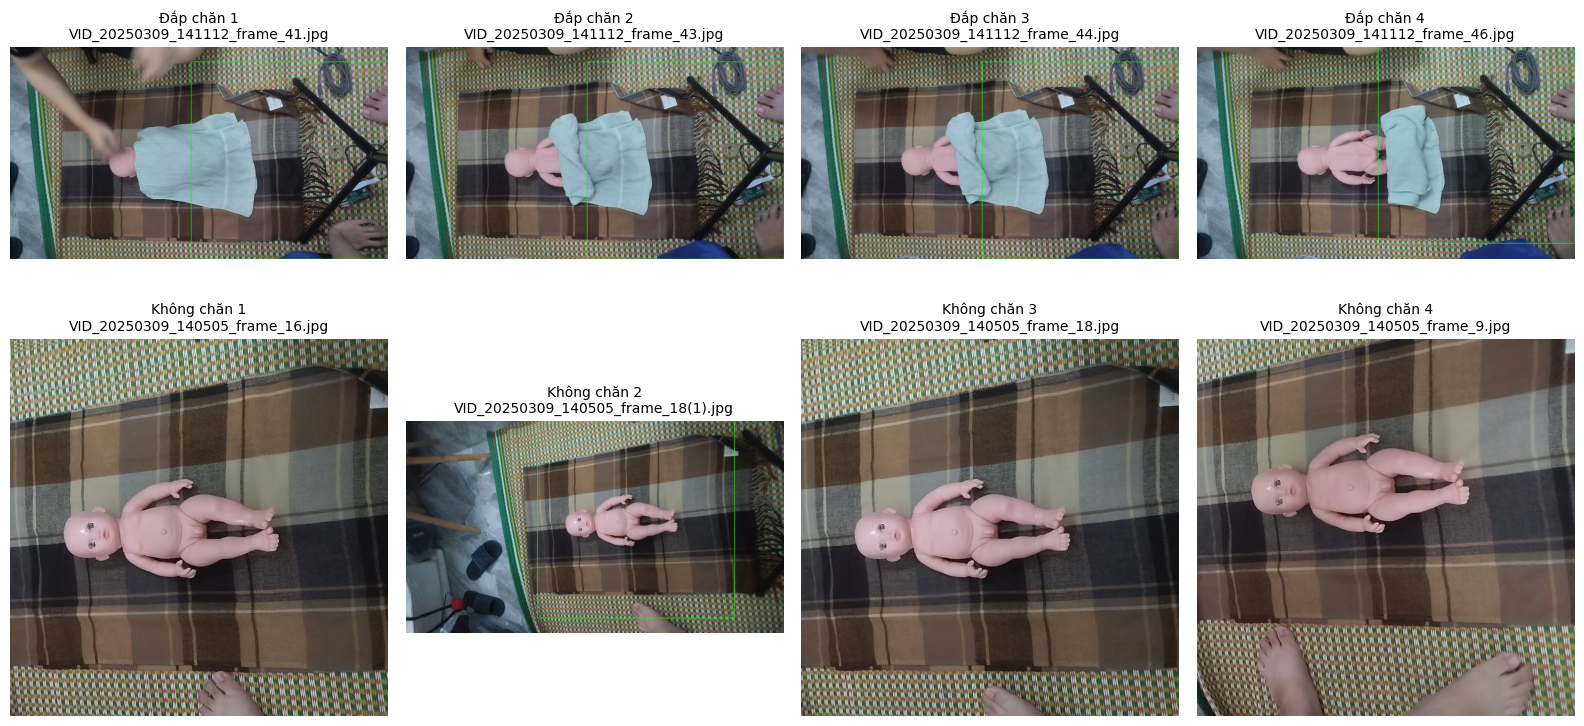


🔍 KIỂM TRA CHI TIẾT CÁC FILE:
Kiểm tra 5 file đầu tiên trong mỗi folder...

--- Folder đắp chăn ---
1. dap_chan\Bản sao của frame_0029 - Copy (2).jpg
   Tồn tại: True
   Kích thước file: 683708 bytes
   ❌ Không thể đọc ảnh
2. dap_chan\Bản sao của frame_0029 - Copy - Copy.jpg
   Tồn tại: True
   Kích thước file: 683708 bytes
   ❌ Không thể đọc ảnh
3. dap_chan\Bản sao của frame_0029 - Copy.jpg
   Tồn tại: True
   Kích thước file: 683708 bytes
   ❌ Không thể đọc ảnh
4. dap_chan\Bản sao của frame_0029.jpg
   Tồn tại: True
   Kích thước file: 683708 bytes
   ❌ Không thể đọc ảnh
5. dap_chan\VID_20250309_141112_frame_41.jpg
   Tồn tại: True
   Kích thước file: 696672 bytes
   ✅ Đọc thành công, shape: (1080, 1920, 3)

--- Folder không chăn ---
1. khong_chan\VID_20250309_140505_frame_16.jpg
   Tồn tại: True
   Kích thước file: 367600 bytes
   ✅ Đọc thành công, shape: (1000, 1000, 3)
2. khong_chan\VID_20250309_140505_frame_18(1).jpg
   Tồn tại: True
   Kích thước file: 639401 bytes
   ✅ Đọc thà

In [4]:
# Thống kê cơ bản
print("=== THỐNG KÊ DỮ LIỆU ===")
print(df['true_label_text'].value_counts())
print("\nTỷ lệ phần trăm:")
print(df['true_label_text'].value_counts(normalize=True) * 100)

# Tạo biểu đồ phân bố
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ cột
df['true_label_text'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Phân bố số lượng ảnh theo nhãn', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loại ảnh')
axes[0].set_ylabel('Số lượng')
axes[0].tick_params(axis='x', rotation=45)

# Thêm giá trị lên đầu mỗi cột
for i, v in enumerate(df['true_label_text'].value_counts().values):
    axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Biểu đồ tròn
df['true_label_text'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                          colors=['skyblue', 'lightcoral'], startangle=90)
axes[1].set_title('Tỷ lệ phân bố ảnh', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Hàm đọc ảnh an toàn
def safe_imread(image_path):
    """
    Đọc ảnh một cách an toàn với error handling
    """
    try:
        # Kiểm tra file tồn tại
        if not os.path.exists(image_path):
            print(f"❌ File không tồn tại: {image_path}")
            return None
            
        # Đọc ảnh
        img = cv2.imread(image_path)
        
        # Kiểm tra ảnh có được đọc thành công không
        if img is None:
            print(f"❌ Không thể đọc ảnh: {image_path}")
            return None
            
        # Convert sang RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb
        
    except Exception as e:
        print(f"❌ Lỗi khi đọc ảnh {image_path}: {str(e)}")
        return None

# Hiển thị một số ảnh mẫu
print("\n=== MỘT SỐ ẢNH MẪU ===")

# Tìm ảnh hợp lệ để hiển thị
valid_dap_chan = []
valid_khong_chan = []

print("Đang kiểm tra ảnh đắp chăn...")
for img_path in dap_chan_images[:8]:  # Kiểm tra 8 ảnh đầu
    img = safe_imread(img_path)
    if img is not None:
        valid_dap_chan.append((img_path, img))
    if len(valid_dap_chan) >= 4:
        break

print("Đang kiểm tra ảnh không chăn...")
for img_path in khong_chan_images[:8]:  # Kiểm tra 8 ảnh đầu
    img = safe_imread(img_path)
    if img is not None:
        valid_khong_chan.append((img_path, img))
    if len(valid_khong_chan) >= 4:
        break

print(f"Tìm được {len(valid_dap_chan)} ảnh đắp chăn hợp lệ")
print(f"Tìm được {len(valid_khong_chan)} ảnh không chăn hợp lệ")

if len(valid_dap_chan) > 0 or len(valid_khong_chan) > 0:
    # Tính số cột cần thiết
    n_cols = max(len(valid_dap_chan), len(valid_khong_chan))
    n_cols = min(n_cols, 4)  # Tối đa 4 cột
    
    if n_cols > 0:
        fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 8))
        
        # Đảm bảo axes là 2D array
        if n_cols == 1:
            axes = axes.reshape(2, 1)
        
        # Hiển thị ảnh đắp chăn
        for i in range(n_cols):
            if i < len(valid_dap_chan):
                img_path, img = valid_dap_chan[i]
                axes[0, i].imshow(img)
                axes[0, i].set_title(f'Đắp chăn {i+1}\n{os.path.basename(img_path)}', fontsize=10)
            else:
                axes[0, i].text(0.5, 0.5, 'Không có ảnh', ha='center', va='center', transform=axes[0, i].transAxes)
                axes[0, i].set_title('Không có ảnh')
            axes[0, i].axis('off')
        
        # Hiển thị ảnh không chăn
        for i in range(n_cols):
            if i < len(valid_khong_chan):
                img_path, img = valid_khong_chan[i]
                axes[1, i].imshow(img)
                axes[1, i].set_title(f'Không chăn {i+1}\n{os.path.basename(img_path)}', fontsize=10)
            else:
                axes[1, i].text(0.5, 0.5, 'Không có ảnh', ha='center', va='center', transform=axes[1, i].transAxes)
                axes[1, i].set_title('Không có ảnh')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Không có ảnh hợp lệ nào để hiển thị!")
else:
    print("❌ Không tìm thấy ảnh hợp lệ nào!")

# Kiểm tra các file có vấn đề
print("\n🔍 KIỂM TRA CHI TIẾT CÁC FILE:")
print("Kiểm tra 5 file đầu tiên trong mỗi folder...")

problem_files = []

print("\n--- Folder đắp chăn ---")
for i, img_path in enumerate(dap_chan_images[:5]):
    print(f"{i+1}. {img_path}")
    print(f"   Tồn tại: {os.path.exists(img_path)}")
    if os.path.exists(img_path):
        print(f"   Kích thước file: {os.path.getsize(img_path)} bytes")
        img = cv2.imread(img_path)
        if img is None:
            print(f"   ❌ Không thể đọc ảnh")
            problem_files.append(img_path)
        else:
            print(f"   ✅ Đọc thành công, shape: {img.shape}")
    else:
        problem_files.append(img_path)

print("\n--- Folder không chăn ---")
for i, img_path in enumerate(khong_chan_images[:5]):
    print(f"{i+1}. {img_path}")
    print(f"   Tồn tại: {os.path.exists(img_path)}")
    if os.path.exists(img_path):
        print(f"   Kích thước file: {os.path.getsize(img_path)} bytes")
        img = cv2.imread(img_path)
        if img is None:
            print(f"   ❌ Không thể đọc ảnh")
            problem_files.append(img_path)
        else:
            print(f"   ✅ Đọc thành công, shape: {img.shape}")
    else:
        problem_files.append(img_path)

if problem_files:
    print(f"\n⚠️ Có {len(problem_files)} file có vấn đề:")
    for file in problem_files:
        print(f"   - {file}")
    
    # Loại bỏ các file có vấn đề khỏi DataFrame
    print("\n🧹 Đang loại bỏ các file có vấn đề khỏi dataset...")
    df_clean = df[~df['image_path'].isin(problem_files)].copy()
    print(f"Dataset ban đầu: {len(df)} ảnh")
    print(f"Dataset sau khi clean: {len(df_clean)} ảnh")
    print(f"Đã loại bỏ: {len(df) - len(df_clean)} ảnh")
    
    # Cập nhật DataFrame
    df = df_clean
    
    # Cập nhật danh sách ảnh
    dap_chan_images = [path for path in dap_chan_images if path not in problem_files]
    khong_chan_images = [path for path in khong_chan_images if path not in problem_files]
    
    print(f"\nSố ảnh đắp chăn còn lại: {len(dap_chan_images)}")
    print(f"Số ảnh không chăn còn lại: {len(khong_chan_images)}")
else:
    print("\n✅ Tất cả file đều ổn!")

In [5]:
def analyze_image_api(image_path):
    """
    Gọi pipeline để phân tích ảnh trực tiếp
    
    Args:
        image_path: Đường dẫn đến ảnh
        
    Returns:
        dict: Kết quả phân tích từ pipeline
    """
    try:
        if pipeline is None:
            raise Exception("Pipeline chưa được khởi tạo")
            
        # Gọi pipeline trực tiếp
        response = pipeline.analyze_image(image_path)
        
        print(f"Analyzing: {os.path.basename(image_path)}")
        print(f"Result success: {response.get('success', False)}")
        
        return {
            'success': response.get('success', False),
            'is_covered': response.get('analysis', {}).get('is_covered', True),
            'coverage_ratio': response.get('analysis', {}).get('coverage_ratio', 0.0),
            'position': response.get('analysis', {}).get('position', 'Unknown'),
            'position_id': response.get('analysis', {}).get('position_id', None),
            'processing_time': response.get('processing_time_ms', 0),
            'probabilities': response.get('analysis', {}).get('probabilities', {}),
            'response': response
        }
            
    except Exception as e:
        print(f"Lỗi khi phân tích ảnh {image_path}: {str(e)}")
        return {
            'success': False,
            'is_covered': True,  # Default value
            'coverage_ratio': 0.0,
            'position': 'Error',
            'position_id': None,
            'processing_time': 0,
            'probabilities': {},
            'error': str(e)
        }

# Test pipeline với 1 ảnh mẫu
if len(df) > 0 and pipeline is not None:
    print("Testing pipeline với ảnh mẫu...")
    test_result = analyze_image_api(df.iloc[0]['image_path'])
    print("Kết quả test:")
    print(json.dumps(test_result, indent=2, ensure_ascii=False))
    print(f"\nPipeline hoạt động: {'✅' if test_result['success'] else '❌'}")
elif pipeline is None:
    print("❌ Pipeline chưa được khởi tạo!")
else:
    print("❌ Không có dữ liệu để test!")

Testing pipeline với ảnh mẫu...
Analyzing: VID_20250309_141112_frame_41.jpg
Result success: True
Kết quả test:
{
  "success": true,
  "is_covered": true,
  "coverage_ratio": 0.6668564081192017,
  "position": "Nằm sấp",
  "position_id": 2,
  "processing_time": 471,
  "probabilities": {
    "Nằm ngửa": 0.01325,
    "Nằm nghiêng": 0.19518648018648016,
    "Nằm sấp": 0.7915635198135198
  },
  "response": {
    "success": true,
    "timestamp": "2025-05-24T15:07:58.998530",
    "analysis": {
      "position": "Nằm sấp",
      "position_id": 2,
      "probabilities": {
        "Nằm ngửa": 0.01325,
        "Nằm nghiêng": 0.19518648018648016,
        "Nằm sấp": 0.7915635198135198
      },
      "is_covered": true,
      "coverage_ratio": 0.6668564081192017
    },
    "annotated_image": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCg

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [ ]:
from tqdm import tqdm
import time

def analyze_all_images(df, batch_size=10, delay=0.05):  # Giảm delay vì không cần HTTP
    """
    Phân tích tất cả ảnh trong DataFrame qua pipeline
    
    Args:
        df: DataFrame chứa thông tin ảnh
        batch_size: Số ảnh xử lý trong mỗi batch
        delay: Thời gian delay giữa các phân tích (giây) - có thể bỏ qua
    
    Returns:
        DataFrame: DataFrame với kết quả phân tích
    """
    if pipeline is None:
        print("❌ Pipeline chưa được khởi tạo!")
        return pd.DataFrame()
        
    results = []
    total_images = len(df)
    
    print(f"Bắt đầu phân tích {total_images} ảnh bằng pipeline...")
    
    with tqdm(total=total_images, desc="Analyzing images") as pbar:
        for idx, row in df.iterrows():
            # Phân tích ảnh
            result = analyze_image_api(row['image_path'])
            
            # Thêm kết quả vào list
            result_row = {
                'image_path': row['image_path'],
                'folder': row['folder'],
                'true_label': row['true_label'],
                'true_label_text': row['true_label_text'],
                'predicted_covered': result['is_covered'],
                'predicted_label': 1 if result['is_covered'] else 0,
                'coverage_ratio': result['coverage_ratio'],
                'position': result['position'],
                'position_id': result['position_id'],
                'processing_time_ms': result['processing_time'],
                'pipeline_success': result['success'],  # Đổi từ api_success
                'probabilities': result['probabilities'],
                'error': result.get('error', None)
            }
            results.append(result_row)
            
            # Cập nhật progress bar
            pbar.set_postfix({
                'Current': os.path.basename(row['image_path'])[:20],
                'Success': result['success'],
                'Predicted': 'Covered' if result['is_covered'] else 'Not covered',
                'Position': result['position']
            })
            pbar.update(1)
            
            # Delay nhỏ (có thể bỏ qua vì không cần thiết cho pipeline local)
            if delay > 0:
                time.sleep(delay)
            
            # In kết quả mỗi batch
            if (idx + 1) % batch_size == 0:
                success_rate = sum(1 for r in results if r['pipeline_success']) / len(results) * 100
                print(f"\nĐã xử lý {idx + 1}/{total_images} ảnh. Tỷ lệ thành công: {success_rate:.1f}%")
    
    return pd.DataFrame(results)

# Chạy phân tích
if pipeline is not None:
    print("🚀 Bắt đầu phân tích tất cả ảnh bằng pipeline...")
    results_df = analyze_all_images(df, batch_size=5, delay=0.01)  # Delay rất nhỏ
    
    print(f"\n✅ Hoàn thành phân tích!")
    print(f"Tổng số ảnh: {len(results_df)}")
    print(f"Thành công: {results_df['pipeline_success'].sum()}")
    print(f"Thất bại: {(~results_df['pipeline_success']).sum()}")
else:
    print("❌ Không thể chạy phân tích vì pipeline chưa được khởi tạo!")
    results_df = pd.DataFrame()  # Empty DataFrame

In [7]:
# Kiểm tra có dữ liệu không
if len(results_df) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    # Lọc chỉ những ảnh được phân tích thành công
    successful_results = results_df[results_df['pipeline_success'] == True].copy()  # Đổi từ api_success
    
    print(f"Số ảnh phân tích thành công: {len(successful_results)}")
    print(f"Số ảnh thất bại: {len(results_df) - len(successful_results)}")
    
    if len(successful_results) == 0:
        print("❌ Không có ảnh nào được phân tích thành công!")
    else:
        # Lấy nhãn thực tế và dự đoán
        y_true = successful_results['true_label'].values
        y_pred = successful_results['predicted_label'].values
        
        # Tính các metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        f1 = f1_score(y_true, y_pred, average='binary')
        
        # Tính precision, recall cho từng class
        precision_per_class = precision_score(y_true, y_pred, average=None)
        recall_per_class = recall_score(y_true, y_pred, average=None)
        f1_per_class = f1_score(y_true, y_pred, average=None)
        
        print("=" * 60)
        print("📊 KẾT QUẢ ĐÁNH GIÁ THUẬT TOÁN PHÁT HIỆN ĐẮP CHĂN (PIPELINE)")
        print("=" * 60)
        print(f"Accuracy (Độ chính xác tổng thể): {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Precision (Độ chính xác dương): {precision:.4f} ({precision*100:.2f}%)")
        print(f"Recall (Độ nhạy): {recall:.4f} ({recall*100:.2f}%)")
        print(f"F1-Score: {f1:.4f} ({f1*100:.2f}%)")
        
        print("\n" + "=" * 40)
        print("📈 CHI TIẾT THEO TỪNG LOẠI:")
        print("=" * 40)
        
        class_names = ['Không đắp chăn (0)', 'Có đắp chăn (1)']
        for i, class_name in enumerate(class_names):
            print(f"\n{class_name}:")
            print(f"  Precision: {precision_per_class[i]:.4f} ({precision_per_class[i]*100:.2f}%)")
            print(f"  Recall: {recall_per_class[i]:.4f} ({recall_per_class[i]*100:.2f}%)")
            print(f"  F1-Score: {f1_per_class[i]:.4f} ({f1_per_class[i]*100:.2f}%)")
        
        # Tạo DataFrame kết quả metrics
        metrics_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
            'Value': [accuracy, precision, recall, f1],
            'Percentage': [f"{accuracy*100:.2f}%", f"{precision*100:.2f}%", 
                          f"{recall*100:.2f}%", f"{f1*100:.2f}%"]
        })
        
        print("\n📋 Bảng tóm tắt metrics:")
        print(metrics_df.to_string(index=False))
        
        # Thêm thống kê về position prediction nếu có
        if 'position' in successful_results.columns:
            print("\n" + "=" * 40)
            print("📍 THỐNG KÊ POSITION PREDICTION:")
            print("=" * 40)
            position_counts = successful_results['position'].value_counts()
            print(position_counts)

Số ảnh phân tích thành công: 59
Số ảnh thất bại: 4
📊 KẾT QUẢ ĐÁNH GIÁ THUẬT TOÁN PHÁT HIỆN ĐẮP CHĂN (PIPELINE)
Accuracy (Độ chính xác tổng thể): 0.8983 (89.83%)
Precision (Độ chính xác dương): 0.8750 (87.50%)
Recall (Độ nhạy): 0.8750 (87.50%)
F1-Score: 0.8750 (87.50%)

📈 CHI TIẾT THEO TỪNG LOẠI:

Không đắp chăn (0):
  Precision: 0.9143 (91.43%)
  Recall: 0.9143 (91.43%)
  F1-Score: 0.9143 (91.43%)

Có đắp chăn (1):
  Precision: 0.8750 (87.50%)
  Recall: 0.8750 (87.50%)
  F1-Score: 0.8750 (87.50%)

📋 Bảng tóm tắt metrics:
   Metric    Value Percentage
 Accuracy 0.898305     89.83%
Precision 0.875000     87.50%
   Recall 0.875000     87.50%
 F1-Score 0.875000     87.50%

📍 THỐNG KÊ POSITION PREDICTION:
position
Nằm ngửa       37
Nằm nghiêng    17
Nằm sấp         5
Name: count, dtype: int64


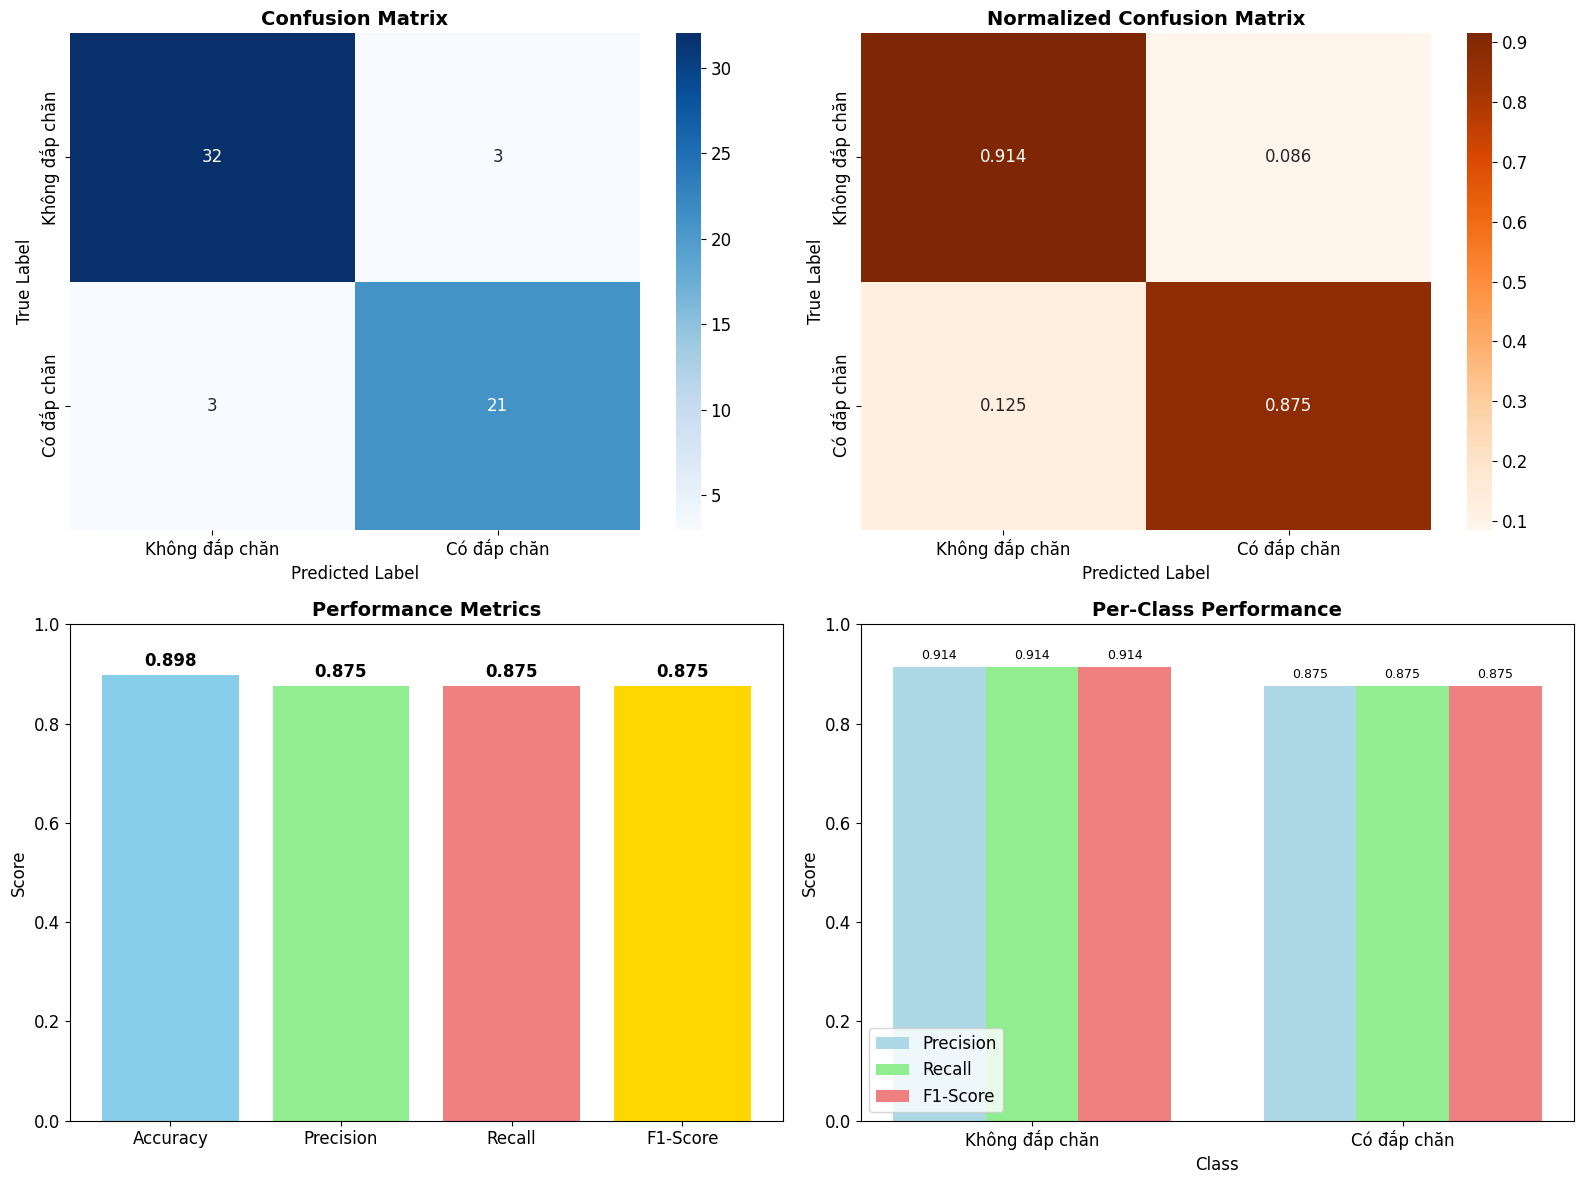


📊 CLASSIFICATION REPORT CHI TIẾT:
                precision    recall  f1-score   support

Không đắp chăn       0.91      0.91      0.91        35
   Có đắp chăn       0.88      0.88      0.88        24

      accuracy                           0.90        59
     macro avg       0.89      0.89      0.89        59
  weighted avg       0.90      0.90      0.90        59



In [8]:
# Kiểm tra có dữ liệu thành công không
if len(results_df) == 0 or 'successful_results' not in locals() or len(successful_results) == 0:
    print("❌ Không có dữ liệu để vẽ biểu đồ!")
else:
    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Tạo figure với subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                xticklabels=['Không đắp chăn', 'Có đắp chăn'],
                yticklabels=['Không đắp chăn', 'Có đắp chăn'])
    axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')
    
    # 2. Normalized Confusion Matrix
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Oranges', ax=axes[0,1],
                xticklabels=['Không đắp chăn', 'Có đắp chăn'],
                yticklabels=['Không đắp chăn', 'Có đắp chăn'])
    axes[0,1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Predicted Label')
    axes[0,1].set_ylabel('True Label')
    
    # 3. Metrics Comparison
    metrics_values = [accuracy, precision, recall, f1]
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    bars = axes[1,0].bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[1,0].set_title('Performance Metrics', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_ylim(0, 1)
    
    # Thêm giá trị lên đầu mỗi cột
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Class-wise Performance
    x = np.arange(len(class_names))
    width = 0.25
    
    bars1 = axes[1,1].bar(x - width, precision_per_class, width, label='Precision', color='lightblue')
    bars2 = axes[1,1].bar(x, recall_per_class, width, label='Recall', color='lightgreen')
    bars3 = axes[1,1].bar(x + width, f1_per_class, width, label='F1-Score', color='lightcoral')
    
    axes[1,1].set_title('Per-Class Performance', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_xlabel('Class')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(['Không đắp chăn', 'Có đắp chăn'])
    axes[1,1].legend()
    axes[1,1].set_ylim(0, 1)
    
    # Thêm giá trị lên đầu mỗi cột
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # In classification report chi tiết
    print("\n📊 CLASSIFICATION REPORT CHI TIẾT:")
    print("=" * 50)
    print(classification_report(y_true, y_pred, 
                              target_names=['Không đắp chăn', 'Có đắp chăn']))

Số trường hợp dự đoán sai: 6
Tỷ lệ dự đoán sai: 10.17%

False Positives (Nhầm không đắp chăn thành có đắp chăn): 3
False Negatives (Nhầm có đắp chăn thành không đắp chăn): 3


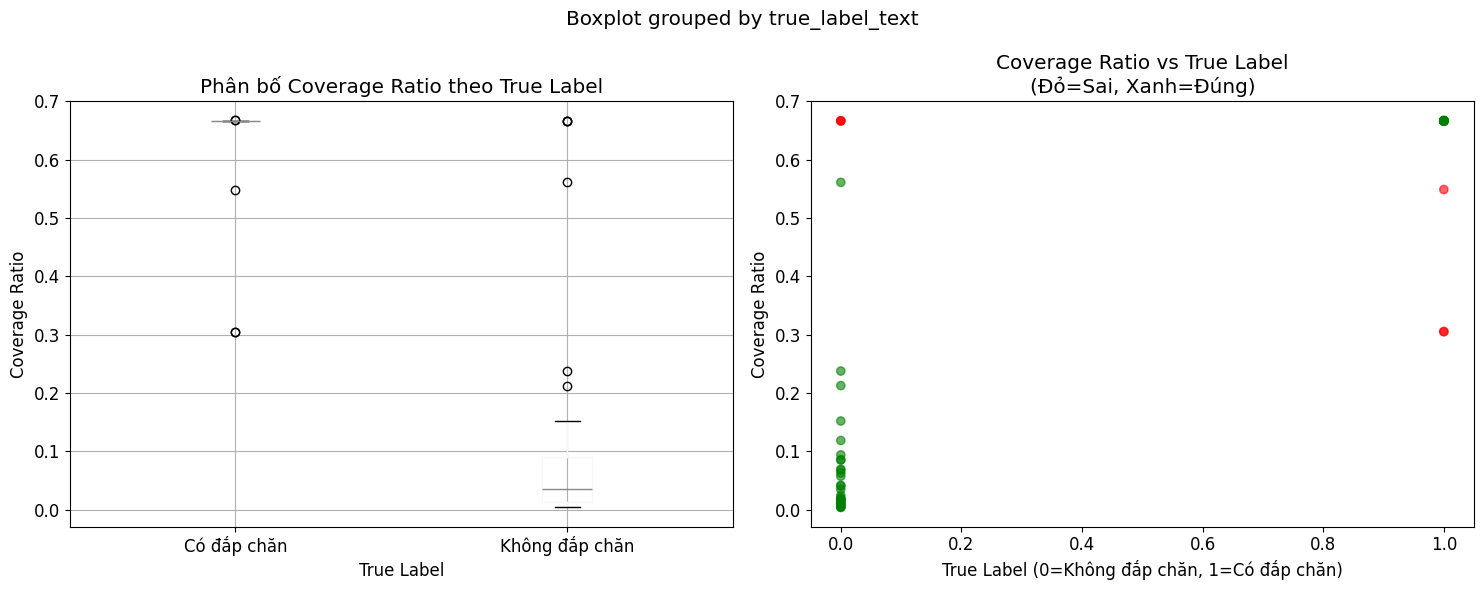


🔍 MỘT SỐ ẢNH DỰ ĐOÁN SAI:


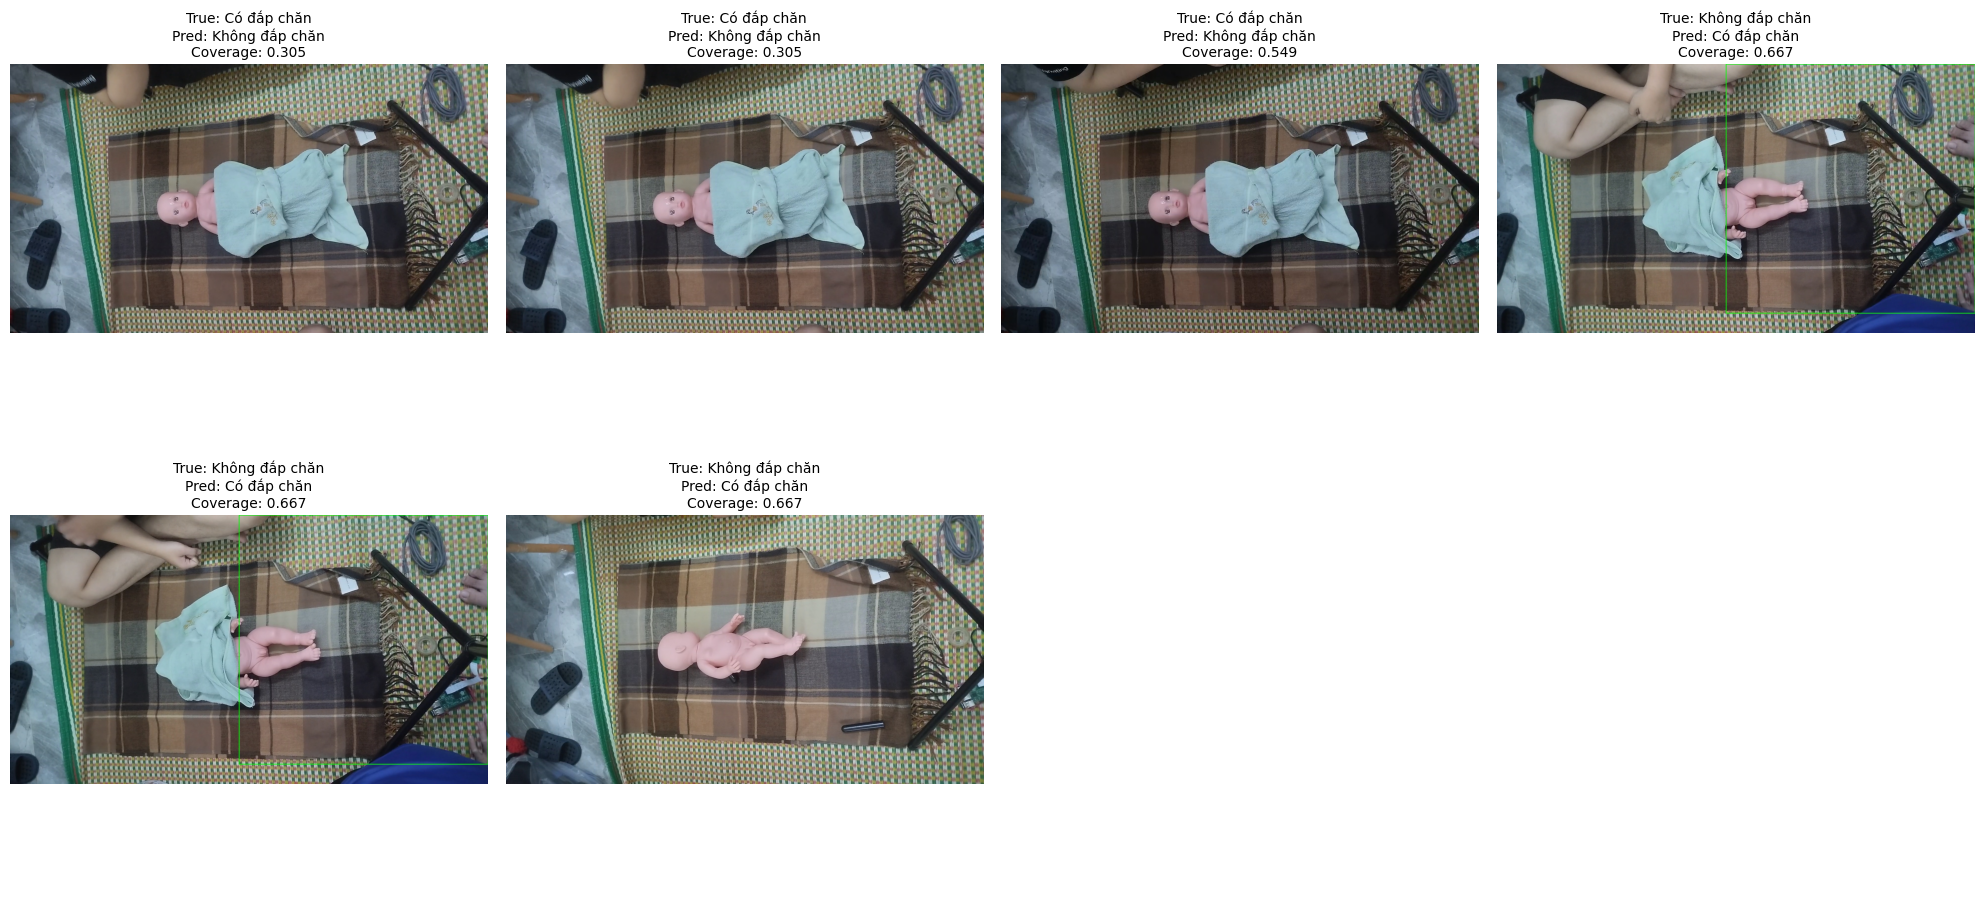


📈 THỐNG KÊ COVERAGE RATIO:
Coverage ratio trung bình: 0.3270
Coverage ratio median: 0.2127
Coverage ratio std: 0.3038

Theo nhãn thực tế:
                     mean    median       std       min       max
true_label_text                                                  
Có đắp chăn      0.631791  0.666749  0.103385  0.305297  0.667437
Không đắp chăn   0.117975  0.034771  0.199147  0.003835  0.666919


In [9]:
# Kiểm tra có dữ liệu thành công không
if len(results_df) == 0 or 'successful_results' not in locals() or len(successful_results) == 0:
    print("❌ Không có dữ liệu để phân tích!")
else:
    # Tìm các trường hợp dự đoán sai
    wrong_predictions = successful_results[successful_results['true_label'] != successful_results['predicted_label']].copy()
    
    print(f"Số trường hợp dự đoán sai: {len(wrong_predictions)}")
    print(f"Tỷ lệ dự đoán sai: {len(wrong_predictions)/len(successful_results)*100:.2f}%")
    
    if len(wrong_predictions) > 0:
        # Phân loại các loại sai
        false_positives = wrong_predictions[wrong_predictions['true_label'] == 0]  # Thực tế không đắp chăn, dự đoán có đắp chăn
        false_negatives = wrong_predictions[wrong_predictions['true_label'] == 1]  # Thực tế có đắp chăn, dự đoán không đắp chăn
        
        print(f"\nFalse Positives (Nhầm không đắp chăn thành có đắp chăn): {len(false_positives)}")
        print(f"False Negatives (Nhầm có đắp chăn thành không đắp chăn): {len(false_negatives)}")
        
        # Biểu đồ phân tích lỗi
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Phân bố coverage ratio theo true label
        successful_results.boxplot(column='coverage_ratio', by='true_label_text', ax=axes[0])
        axes[0].set_title('Phân bố Coverage Ratio theo True Label')
        axes[0].set_xlabel('True Label')
        axes[0].set_ylabel('Coverage Ratio')
        
        # Scatter plot: Coverage ratio vs True/Predicted
        colors = ['red' if row['true_label'] != row['predicted_label'] else 'green' 
                  for _, row in successful_results.iterrows()]
        axes[1].scatter(successful_results['true_label'], successful_results['coverage_ratio'], 
                       c=colors, alpha=0.6)
        axes[1].set_xlabel('True Label (0=Không đắp chăn, 1=Có đắp chăn)')
        axes[1].set_ylabel('Coverage Ratio')
        axes[1].set_title('Coverage Ratio vs True Label\n(Đỏ=Sai, Xanh=Đúng)')
        
        plt.tight_layout()
        plt.show()
        
        # Hiển thị một số ảnh dự đoán sai
        if len(wrong_predictions) > 0:
            print("\n🔍 MỘT SỐ ẢNH DỰ ĐOÁN SAI:")
            
            # Hiển thị tối đa 8 ảnh sai
            n_display = min(8, len(wrong_predictions))
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.flatten()
            
            for i in range(n_display):
                row = wrong_predictions.iloc[i]
                
                # Đọc và hiển thị ảnh
                img = safe_imread(row['image_path'])
                if img is not None:
                    axes[i].imshow(img)
                    title = f"True: {row['true_label_text']}\n"
                    title += f"Pred: {'Có đắp chăn' if row['predicted_covered'] else 'Không đắp chăn'}\n"
                    title += f"Coverage: {row['coverage_ratio']:.3f}"
                    axes[i].set_title(title, fontsize=10)
                else:
                    axes[i].text(0.5, 0.5, 'Không thể\nđọc ảnh', ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(f"Error: {os.path.basename(row['image_path'])}", fontsize=10)
                axes[i].axis('off')
            
            # Ẩn các subplot thừa
            for i in range(n_display, len(axes)):
                axes[i].axis('off')
                
            plt.tight_layout()
            plt.show()
    
    # Thống kê coverage ratio
    print(f"\n📈 THỐNG KÊ COVERAGE RATIO:")
    print(f"Coverage ratio trung bình: {successful_results['coverage_ratio'].mean():.4f}")
    print(f"Coverage ratio median: {successful_results['coverage_ratio'].median():.4f}")
    print(f"Coverage ratio std: {successful_results['coverage_ratio'].std():.4f}")
    
    print(f"\nTheo nhãn thực tế:")
    coverage_stats = successful_results.groupby('true_label_text')['coverage_ratio'].agg(['mean', 'median', 'std', 'min', 'max'])
    print(coverage_stats)

In [10]:
# Kiểm tra có dữ liệu không
if len(results_df) == 0:
    print("❌ Không có dữ liệu để lưu!")
else:
    # Lưu kết quả vào file
    results_df.to_csv('blanket_detection_results_pipeline.csv', index=False, encoding='utf-8')
    print("✅ Đã lưu kết quả vào file 'blanket_detection_results_pipeline.csv'")
    
    # Lấy thông tin cho báo cáo
    if 'successful_results' in locals() and len(successful_results) > 0:
        wrong_predictions = successful_results[successful_results['true_label'] != successful_results['predicted_label']]
        false_positives = wrong_predictions[wrong_predictions['true_label'] == 0]
        false_negatives = wrong_predictions[wrong_predictions['true_label'] == 1]
        
        # Tạo báo cáo tóm tắt
        report = f"""
=== BÁO CÁO ĐÁNH GIÁ THUẬT TOÁN PHÁT HIỆN ĐẮP CHĂN (PIPELINE) ===

📊 THÔNG TIN DATASET:
- Tổng số ảnh: {len(df)}
- Ảnh có đắp chăn: {len([x for x in df['true_label'] if x == 1])}
- Ảnh không đắp chăn: {len([x for x in df['true_label'] if x == 0])}
- Ảnh phân tích thành công: {len(successful_results)}
- Ảnh thất bại: {len(results_df) - len(successful_results)}

🎯 KẾT QUẢ PERFORMANCE:
- Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)
- Precision: {precision:.4f} ({precision*100:.2f}%)
- Recall: {recall:.4f} ({recall*100:.2f}%)
- F1-Score: {f1:.4f} ({f1*100:.2f}%)

❌ PHÂN TÍCH LỖI:
- Tổng số dự đoán sai: {len(wrong_predictions)}
- False Positives: {len(false_positives)}
- False Negatives: {len(false_negatives)}
- Tỷ lệ lỗi: {len(wrong_predictions)/len(successful_results)*100:.2f}%

📈 COVERAGE RATIO STATS:
- Trung bình: {successful_results['coverage_ratio'].mean():.4f}
- Median: {successful_results['coverage_ratio'].median():.4f}
- Std: {successful_results['coverage_ratio'].std():.4f}

⏱️ PERFORMANCE:
- Thời gian xử lý trung bình: {successful_results['processing_time_ms'].mean():.1f}ms
- Thời gian xử lý median: {successful_results['processing_time_ms'].median():.1f}ms

🔧 PIPELINE INFO:
- Sử dụng pipeline trực tiếp (không qua API)
- Model path: {MODEL_PATH}
- Scaler path: {SCALER_PATH}
"""
        
        print(report)
        
        # Lưu báo cáo
        with open('blanket_detection_report_pipeline.txt', 'w', encoding='utf-8') as f:
            f.write(report)
        print("✅ Đã lưu báo cáo vào file 'blanket_detection_report_pipeline.txt'")
        
        print("\n🎉 HOÀN THÀNH ĐÁNH GIÁ THUẬT TOÁN BẰNG PIPELINE!")
    else:
        print("❌ Không có dữ liệu thành công để tạo báo cáo chi tiết!")
        
        # Tạo báo cáo cơ bản
        basic_report = f"""
=== BÁO CÁO CƠ BẢN ===

📊 THÔNG TIN DATASET:
- Tổng số ảnh: {len(df)}
- Ảnh được xử lý: {len(results_df)}
- Ảnh thành công: {results_df['pipeline_success'].sum() if len(results_df) > 0 else 0}
- Ảnh thất bại: {(~results_df['pipeline_success']).sum() if len(results_df) > 0 else len(results_df)}

⚠️ CẢNH BÁO: Không có ảnh nào được phân tích thành công!
"""
        print(basic_report)
        
        with open('blanket_detection_report_pipeline.txt', 'w', encoding='utf-8') as f:
            f.write(basic_report)
        print("✅ Đã lưu báo cáo cơ bản vào file")
    
    # Đóng pipeline
    if pipeline:
        pipeline.close()
        print("✅ Đã đóng pipeline")

print("\n🏁 HOÀN THÀNH TẤT CẢ CÁC BƯỚC ĐÁNH GIÁ!")

✅ Đã lưu kết quả vào file 'blanket_detection_results_pipeline.csv'

=== BÁO CÁO ĐÁNH GIÁ THUẬT TOÁN PHÁT HIỆN ĐẮP CHĂN (PIPELINE) ===

📊 THÔNG TIN DATASET:
- Tổng số ảnh: 63
- Ảnh có đắp chăn: 27
- Ảnh không đắp chăn: 36
- Ảnh phân tích thành công: 59
- Ảnh thất bại: 4

🎯 KẾT QUẢ PERFORMANCE:
- Accuracy: 0.8983 (89.83%)
- Precision: 0.8750 (87.50%)
- Recall: 0.8750 (87.50%)
- F1-Score: 0.8750 (87.50%)

❌ PHÂN TÍCH LỖI:
- Tổng số dự đoán sai: 6
- False Positives: 3
- False Negatives: 3
- Tỷ lệ lỗi: 10.17%

📈 COVERAGE RATIO STATS:
- Trung bình: 0.3270
- Median: 0.2127
- Std: 0.3038

⏱️ PERFORMANCE:
- Thời gian xử lý trung bình: 418.8ms
- Thời gian xử lý median: 417.0ms

🔧 PIPELINE INFO:
- Sử dụng pipeline trực tiếp (không qua API)
- Model path: app/models/random_forest.pkl
- Scaler path: app/models/input_scaler.pkl

✅ Đã lưu báo cáo vào file 'blanket_detection_report_pipeline.txt'

🎉 HOÀN THÀNH ĐÁNH GIÁ THUẬT TOÁN BẰNG PIPELINE!
✅ Đã đóng pipeline

🏁 HOÀN THÀNH TẤT CẢ CÁC BƯỚC ĐÁNH GIÁ!
